Version1:
Raw Data Processing;

In [1]:
import torch.utils.data as data
import numpy as np
import os, sys
import data_transforms

import random
import os
import json
import torch
import torchvision.transforms as transforms
import pickle
import math
import time
import io123
IO = io123.IO
all_load_times = []
all_process_times = []

def rotation_z(pts, theta):
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    rotation_matrix = np.array([[cos_theta, -sin_theta, 0.0],
                                [sin_theta, cos_theta, 0.0],
                                [0.0, 0.0, 1.0]])
    return pts @ rotation_matrix.T


def rotation_y(pts, theta):
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    rotation_matrix = np.array([[cos_theta, 0.0, -sin_theta],
                                [0.0, 1.0, 0.0],
                                [sin_theta, 0.0, cos_theta]])
    return pts @ rotation_matrix.T


def rotation_x(pts, theta):
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    rotation_matrix = np.array([[1.0, 0.0, 0.0],
                                [0.0, cos_theta, -sin_theta],
                                [0.0, sin_theta, cos_theta]])
    return pts @ rotation_matrix.T


class Shapenet_ViPC(data.Dataset):
    # def __init__(self, data_root, subset, class_choice = None):
    def __init__(self, subset,View_align):
        self.partial_points_path = "./data/Partial/%s/%s/%s.dat"
        self.complete_points_path = "./data/GT/%s/%s/%s.dat"
        self.view_path = "./data/view/%s/%s/rendering/%s.png"
        self.category_file = "%s_list2.txt"
        self.npoints = 3500
        self.subset = subset
        self.category = "all" 
        self.cat_map = {
            'plane':'02691156',
            'bench': '02828884', 
            'cabinet':'02933112', 
            'car':'02958343',
            'chair':'03001627',
            'monitor': '03211117',
            'lamp':'03636649',
            'speaker': '03691459', 
            'firearm': '04090263', 
            'couch':'04256520',
            'table':'04379243',
            'cellphone': '04401088', 
            'watercraft':'04530566'
        }
        self.filelist = []
        self.cat = []
        self.key = []
        self.filepath = self.category_file % self.subset
        self.view_align = View_align

        with open(self.filepath,'r') as f:
            line = f.readline()
            while (line):
                self.filelist.append(line)
                line = f.readline()

        for key in self.filelist:
            if self.category !='all':
                if key.split(';')[0]!= self.cat_map[self.category]:
                    continue
            self.cat.append(key.split(';')[0])
            self.key.append(key)
        self.img_transforms = self._img_get_transforms(self.subset)

    def _img_get_transforms(self,subset):
        if subset == 'train':
            transform1 = transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),   
               
            ])
        else:
            transform1 = transforms.Compose([ 
                transforms.Resize(224),
                transforms.ToTensor(),   
            ])
        return transform1


    def __getitem__(self, idx):

        data_loading_time = 0
        data_processing_time = 0
        
        key = self.key[idx]
        pc_part_path = self.partial_points_path % (key.split(';')[0],key.split(';')[1], key.split(';')[-1].replace('\n', ''))
        # pc_part_path = os.path.join(self.imcomplete_path,key.split(';')[0]+'/'+ key.split(';')[1]+'/'+key.split(';')[-1].replace('\n', '')+'.dat')
        
        if self.view_align:
            ran_key = key        
        else:
            ran_key = key[:-3]+str(random.randint(0,23)).rjust(2,'0')
        
        pc_path = self.complete_points_path % (ran_key.split(';')[0], ran_key.split(';')[1], ran_key.split(';')[-1].replace('\n', ''))
        # pc_path = os.path.join(self.gt_path, ran_key.split(';')[0]+'/'+ ran_key.split(';')[1]+'/'+ran_key.split(';')[-1].replace('\n', '')+'.dat')
        view_path = self.view_path % (ran_key.split(';')[0], ran_key.split(';')[1], ran_key.split(';')[-1].replace('\n','')) 
        if(len(ran_key.split(';')[-1])>3):
            print("bug")
            print(ran_key.split(';')[-1])
            fin = ran_key.split(';')[-1][-2:]
            interm = ran_key.split(';')[-1][:-2]
            pc_path = self.complete_points_path % (ran_key.split(';')[0],  interm +'/', fin.replace('\n', ''))          
            view_path = self.view_path % (ran_key.split(';')[0]+ '/', interm , fin.replace('\n',''))
        
        load_start_time = time.time()
        views = IO.get(view_path)
        # load gt points
        with open(pc_path,'rb') as f:
            pc = pickle.load(f).astype(np.float32)
        # load partial points
        with open(pc_part_path,'rb') as f:
            pc_part = pickle.load(f).astype(np.float32)

        view_metadata = np.loadtxt(view_path[:-6]+'rendering_metadata.txt')

        data_loading_time = time.time() - load_start_time

        process_start_time = time.time()
        # incase some item point number less than 3500 
        if pc_part.shape[0]<self.npoints:
            pc_part = np.repeat(pc_part,(self.npoints//pc_part.shape[0])+1,axis=0)[0:self.npoints]
        views = self.img_transforms(views)
        views = views[:3,:,:]

        
        # load the view metadata
        image_view_id = view_path.split('/')[-1].split('.')[0]
        part_view_id = pc_part_path.split('/')[-1].split('.')[0]
        # print(pc_path)
        # print(view_path)
        # print(image_view_id)
        # print(part_view_id)

        theta_part = math.radians(view_metadata[int(part_view_id),0])
        phi_part = math.radians(view_metadata[int(part_view_id),1])

        theta_img = math.radians(view_metadata[int(image_view_id),0])
        phi_img = math.radians(view_metadata[int(image_view_id),1])

        pc_part = rotation_y(rotation_x(pc_part, - phi_part),np.pi + theta_part)
        pc_part = rotation_x(rotation_y(pc_part, np.pi - theta_img), phi_img)

        # normalize partial point cloud and GT to the same scale
        gt_mean = pc.mean(axis=0) 
        pc = pc - gt_mean
        pc_L_max = np.max(np.sqrt(np.sum(abs(pc ** 2), axis=-1)))
        pc = pc/pc_L_max

        pc_part = pc_part-gt_mean
        pc_part = pc_part/pc_L_max

        data_processing_time = time.time()-process_start_time
  

        return ran_key.split(';')[0], ran_key.split(';')[1], (torch.from_numpy(pc_part).float(), torch.from_numpy(pc).float(),views.float()),torch.tensor(data_loading_time), torch.tensor(data_processing_time)
    
    def __len__(self):
        return len(self.key)

train_data = Shapenet_ViPC("train",True)
test_data = Shapenet_ViPC("test",True)


In [2]:
shuffle = 1

In [3]:
def data_test(bs,num_workers):
    def worker_init_fn(worker_id):
        np.random.seed(np.random.get_state()[1][0] + worker_id)

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=bs,
                                                        shuffle = shuffle, 
                                                        drop_last = True,
                                                        num_workers = num_workers,
                                                        worker_init_fn=worker_init_fn,
                                                        pin_memory = True)

    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=bs,
                                                        shuffle = shuffle, 
                                                        drop_last = False,
                                                        num_workers = num_workers,
                                                        worker_init_fn=worker_init_fn,
                                                        pin_memory = True)
    max_epoch =10

    all_data_times = []

    all_load_times = []
    all_process_times = []

    for epoch in range(0, max_epoch + 1):
        batch_start_time = time.time()
        n_batches = len(train_dataloader)
        epoch_data_times = []
        for idx, (taxonomy_ids, model_ids, data,load_times,process_times) in enumerate(train_dataloader):
                # print("data2:",data[0].shape)
                data_time= time.time() - batch_start_time 
                if num_workers !=0:
                    load_times = load_times.reshape(-1).sum()
                    process_times = process_times.reshape(-1).sum()
                else:
                    load_times = load_times.reshape(-1).sum()
                    process_times = process_times.reshape(-1).sum() 
                # print(load_times.shape)
                print('[Epoch %d/%d][Batch %d/%d] DataTime = %.3f (s) LoadTime = %f(s) ProcessTime = %f(s)' %
                                (epoch, max_epoch, idx + 1, n_batches, data_time,load_times,process_times))
                all_data_times.append(data_time)

                # load_times = load_times.reshape(-1).mean()
                # process_times = process_times.reshape(-1).mean()
                all_load_times.append(load_times)
                all_process_times.append(process_times)
                batch_start_time = time.time()

                
    import matplotlib.pyplot as plt
    mean_load_time = sum(all_load_times) / len(all_load_times)
    mean_process_time = sum(all_process_times) / len(all_process_times)
    mean_data_time = sum(all_data_times) / len(all_data_times)

    # 绘制图像
    plt.figure(figsize=(10, 6))
    plt.plot(all_data_times, label="Total Data Time per Batch", color='b')
    plt.plot(all_load_times, label="Data Loading Time", color='g')
    plt.plot(all_process_times, label="Data Processing Time", color='orange')

    plt.axhline(mean_data_time, color='r', linestyle='--', label=f"Mean Total Time = {mean_data_time:.3f} s")
    plt.axhline(mean_load_time, color='g', linestyle='--', label=f"Mean Load Time = {mean_load_time:.3f} s")
    plt.axhline(mean_process_time, color='orange', linestyle='--', label=f"Mean Process Time = {mean_process_time:.3f} s")
    plt.yticks([mean_load_time,mean_process_time,mean_data_time])

    plt.xlabel('Batch')
    plt.ylabel('Time (s)')
    plt.title(f'Batchsize:{bs}, Num_workers:{num_workers}')
    plt.legend()
    plt.grid(True)
    plt.show()

[Epoch 0/10][Batch 1/3] DataTime = 1.753 (s) LoadTime = 0.068014(s) ProcessTime = 0.214585(s)
[Epoch 0/10][Batch 2/3] DataTime = 0.366 (s) LoadTime = 0.054257(s) ProcessTime = 0.200078(s)
[Epoch 0/10][Batch 3/3] DataTime = 0.273 (s) LoadTime = 0.057073(s) ProcessTime = 0.183373(s)
[Epoch 1/10][Batch 1/3] DataTime = 0.259 (s) LoadTime = 0.056686(s) ProcessTime = 0.174087(s)
[Epoch 1/10][Batch 2/3] DataTime = 0.249 (s) LoadTime = 0.053075(s) ProcessTime = 0.163111(s)
[Epoch 1/10][Batch 3/3] DataTime = 0.236 (s) LoadTime = 0.052093(s) ProcessTime = 0.155887(s)
[Epoch 2/10][Batch 1/3] DataTime = 0.239 (s) LoadTime = 0.052156(s) ProcessTime = 0.156311(s)
[Epoch 2/10][Batch 2/3] DataTime = 0.233 (s) LoadTime = 0.052589(s) ProcessTime = 0.152399(s)
[Epoch 2/10][Batch 3/3] DataTime = 0.237 (s) LoadTime = 0.052001(s) ProcessTime = 0.152570(s)
[Epoch 3/10][Batch 1/3] DataTime = 0.235 (s) LoadTime = 0.053062(s) ProcessTime = 0.152631(s)
[Epoch 3/10][Batch 2/3] DataTime = 0.238 (s) LoadTime = 0.05

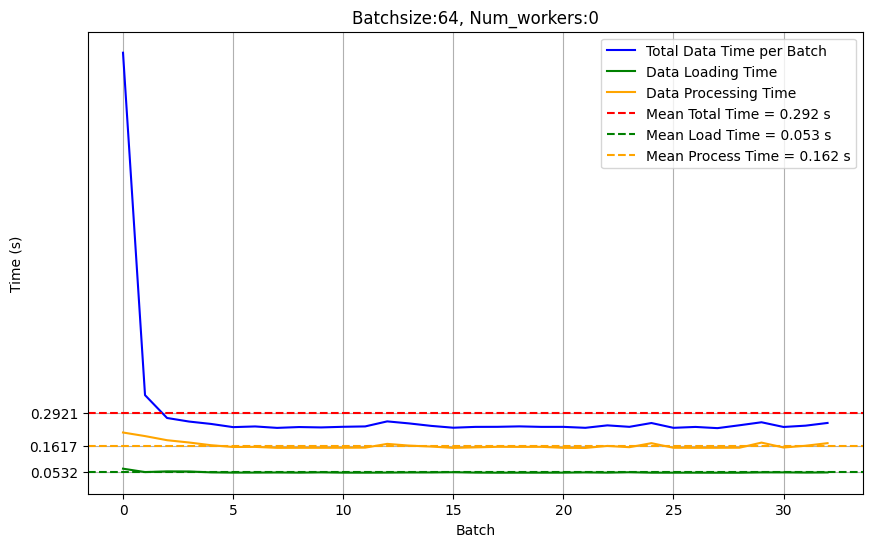

[Epoch 0/10][Batch 1/3] DataTime = 0.450 (s) LoadTime = 0.062280(s) ProcessTime = 0.240249(s)
[Epoch 0/10][Batch 2/3] DataTime = 0.268 (s) LoadTime = 0.056135(s) ProcessTime = 0.188656(s)
[Epoch 0/10][Batch 3/3] DataTime = 0.206 (s) LoadTime = 0.046318(s) ProcessTime = 0.135480(s)
[Epoch 1/10][Batch 1/3] DataTime = 0.448 (s) LoadTime = 0.063878(s) ProcessTime = 0.248314(s)
[Epoch 1/10][Batch 2/3] DataTime = 0.281 (s) LoadTime = 0.059214(s) ProcessTime = 0.184293(s)
[Epoch 1/10][Batch 3/3] DataTime = 0.298 (s) LoadTime = 0.061279(s) ProcessTime = 0.196476(s)
[Epoch 2/10][Batch 1/3] DataTime = 0.450 (s) LoadTime = 0.063478(s) ProcessTime = 0.245440(s)
[Epoch 2/10][Batch 2/3] DataTime = 0.278 (s) LoadTime = 0.063644(s) ProcessTime = 0.185845(s)
[Epoch 2/10][Batch 3/3] DataTime = 0.213 (s) LoadTime = 0.046557(s) ProcessTime = 0.133994(s)
[Epoch 3/10][Batch 1/3] DataTime = 0.444 (s) LoadTime = 0.063995(s) ProcessTime = 0.243875(s)
[Epoch 3/10][Batch 2/3] DataTime = 0.261 (s) LoadTime = 0.06

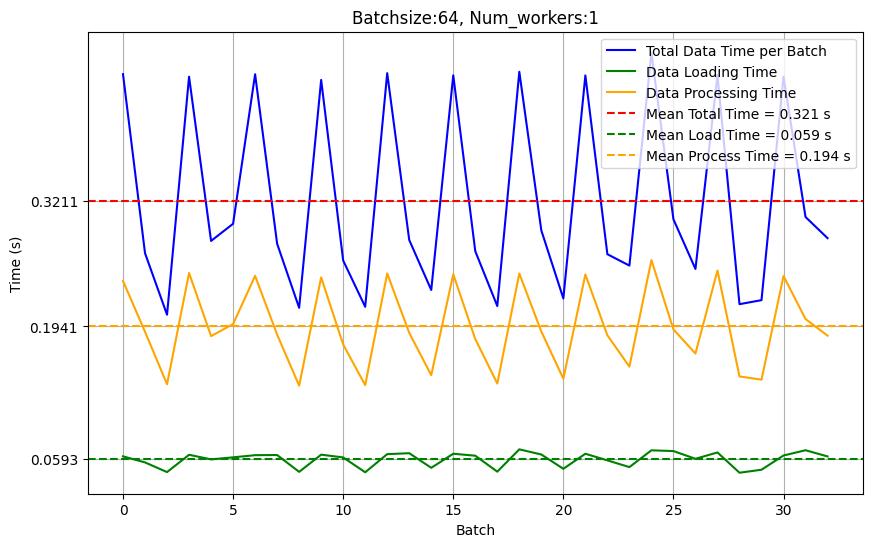

[Epoch 0/10][Batch 1/3] DataTime = 0.478 (s) LoadTime = 0.068563(s) ProcessTime = 0.263771(s)
[Epoch 0/10][Batch 2/3] DataTime = 0.042 (s) LoadTime = 0.068192(s) ProcessTime = 0.262414(s)
[Epoch 0/10][Batch 3/3] DataTime = 0.243 (s) LoadTime = 0.062862(s) ProcessTime = 0.187508(s)
[Epoch 1/10][Batch 1/3] DataTime = 0.559 (s) LoadTime = 0.065717(s) ProcessTime = 0.251441(s)
[Epoch 1/10][Batch 2/3] DataTime = 0.001 (s) LoadTime = 0.063488(s) ProcessTime = 0.242633(s)
[Epoch 1/10][Batch 3/3] DataTime = 0.204 (s) LoadTime = 0.065683(s) ProcessTime = 0.188018(s)
[Epoch 2/10][Batch 1/3] DataTime = 0.494 (s) LoadTime = 0.065210(s) ProcessTime = 0.246238(s)
[Epoch 2/10][Batch 2/3] DataTime = 0.001 (s) LoadTime = 0.062728(s) ProcessTime = 0.242484(s)
[Epoch 2/10][Batch 3/3] DataTime = 0.266 (s) LoadTime = 0.064923(s) ProcessTime = 0.192633(s)
[Epoch 3/10][Batch 1/3] DataTime = 0.470 (s) LoadTime = 0.065514(s) ProcessTime = 0.247301(s)
[Epoch 3/10][Batch 2/3] DataTime = 0.046 (s) LoadTime = 0.06

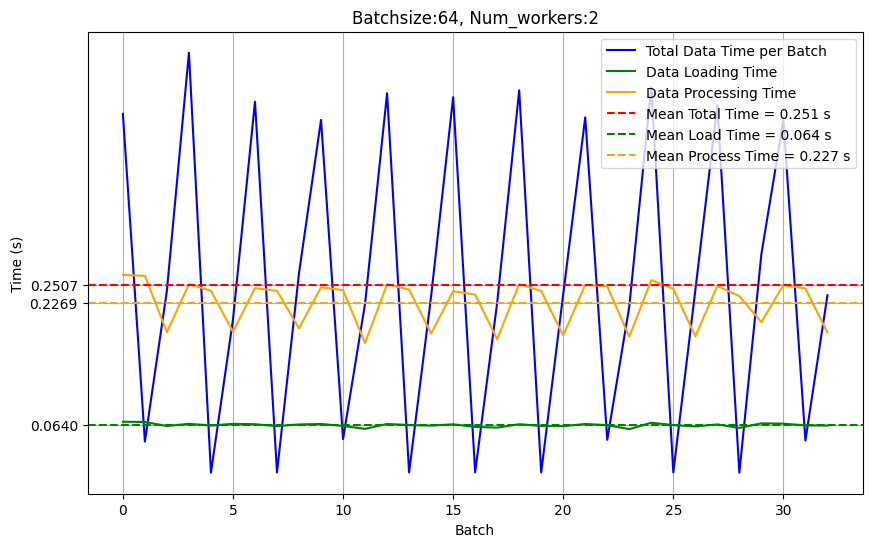

[Epoch 0/10][Batch 1/3] DataTime = 0.607 (s) LoadTime = 0.068906(s) ProcessTime = 0.264425(s)
[Epoch 0/10][Batch 2/3] DataTime = 0.001 (s) LoadTime = 0.068341(s) ProcessTime = 0.262755(s)
[Epoch 0/10][Batch 3/3] DataTime = 0.000 (s) LoadTime = 0.065746(s) ProcessTime = 0.251612(s)
[Epoch 1/10][Batch 1/3] DataTime = 0.562 (s) LoadTime = 0.065309(s) ProcessTime = 0.251777(s)
[Epoch 1/10][Batch 2/3] DataTime = 0.036 (s) LoadTime = 0.064976(s) ProcessTime = 0.252017(s)
[Epoch 1/10][Batch 3/3] DataTime = 0.000 (s) LoadTime = 0.065026(s) ProcessTime = 0.251445(s)
[Epoch 2/10][Batch 1/3] DataTime = 0.656 (s) LoadTime = 0.070120(s) ProcessTime = 0.265164(s)
[Epoch 2/10][Batch 2/3] DataTime = 0.001 (s) LoadTime = 0.064517(s) ProcessTime = 0.249534(s)
[Epoch 2/10][Batch 3/3] DataTime = 0.000 (s) LoadTime = 0.069315(s) ProcessTime = 0.263471(s)
[Epoch 3/10][Batch 1/3] DataTime = 0.615 (s) LoadTime = 0.074865(s) ProcessTime = 0.284924(s)
[Epoch 3/10][Batch 2/3] DataTime = 0.001 (s) LoadTime = 0.06

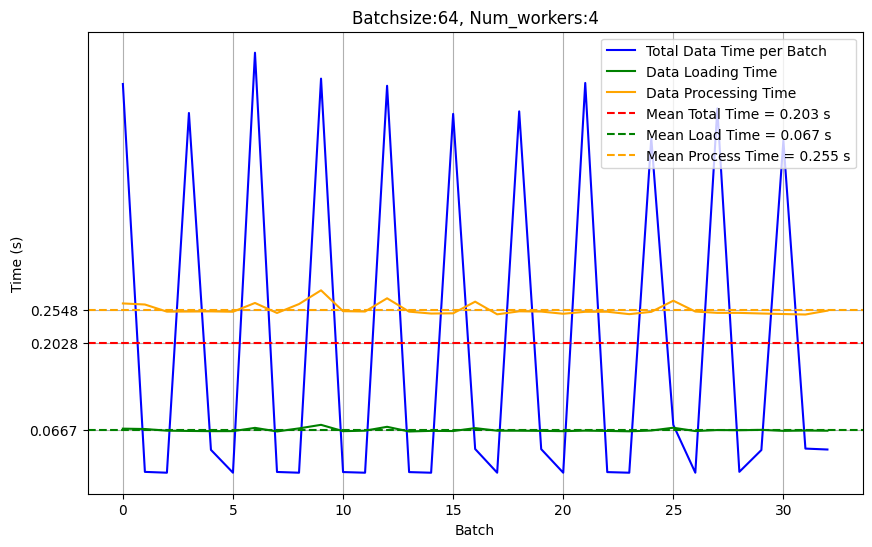

In [4]:
parmaters = [[64,0],[64,1],[64,2],[64,4]]

for par in parmaters:
    data_test(*par)